In [10]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, l2norm
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.ksd.kernel import l2norm

from src.sensors import Sensor, SensorImproper

MCMCKernel = RandomWalkMH # RandomWalkBarker 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pompe's paper

In [ ]:
tf.random.set_seed(1)

In [3]:
loc_true = tf.constant([
    [0.125, 0.81],
    [0.225, 0.475],
    [0.35, 0.1],
    [0.45, 0.22],
    [0.55, 0.73],
    [0.57, 0.93],
    [0.85, 0.05],
    [0.85, 0.8],
    [0.3, 0.7],
    [0.5, 0.3], 
    [0.7, 0.7],])

dist_true = tf.math.sqrt(l2norm(loc_true, loc_true))
dist_noise = tf.random.normal((loc_true.shape[0], loc_true.shape[0])) * 0.02
assert dist_noise.shape == (11, 11)
dist_noise = tf.experimental.numpy.triu(dist_noise, 1)
dist_noise += tf.transpose(dist_noise)
dist_true += dist_noise
assert tf.experimental.numpy.allclose(dist_true, tf.transpose(dist_true))

# Observation indicators for the sensors
## potentially wrong links (1 -- 11): 
## (3, 8)
O_true = tf.constant([
    [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
    [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
    [0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
    [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
    [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
    [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
])
assert tf.experimental.numpy.allclose(O_true, tf.transpose(O_true))

# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob = O_true[:8, 8:] # 8 x 3

# Observation indicators among the first four sensors. 
Os = O_true[:8, :8] # 8 x 8

# Each row indicates the location of the known sensors (9th to 11th).
Xb = loc_true[8:] # 3 x 2

# Each row indicates the location of the unknown sensors (1st to 8th).
Xs = loc_true[:8] # 8 x 2

# The observed distances from the observed sensors (each col) to the unobserved sensors.
Yb = (dist_true * O_true)[:8, 8:] # 8 x 3

# Observed distances among the first 8 sensors.
Ys = (dist_true * O_true)[:8, :8] # 8 x 8

In [4]:
target = SensorImproper(Ob, Os, Xb, Xs, Yb, Ys)
log_prob_fn = target.log_prob

In [5]:
tf.random.set_seed(1)

loc = tf.random.uniform((1, 16))
loc2 = tf.concat([loc, loc, loc], axis=0)
pp2 = log_prob_fn(loc2) - 25.
print(pp2)

loc3 = tf.concat([loc2, loc2], axis=0)
pp3 = log_prob_fn(loc3) - 25.
print(pp3)

tf.Tensor([-1403.2502 -1403.2502 -1403.2502], shape=(3,), dtype=float32)
tf.Tensor([-1403.2502 -1403.2502 -1403.2502 -1403.2502 -1403.2502 -1403.2502], shape=(6,), dtype=float32)


In [6]:
dim = 16

n = 1000
ind = tf.range(start=0, limit=200000, delta=200000//n)
# ind = tf.range(start=0, limit=100000, delta=100000//n)
# ind = range(n)

mcmc_res = pd.read_csv("res/sensors/res_ram_improper2.csv")
samples_off = tf.constant(mcmc_res.loc[ind].to_numpy(), dtype=tf.float32)

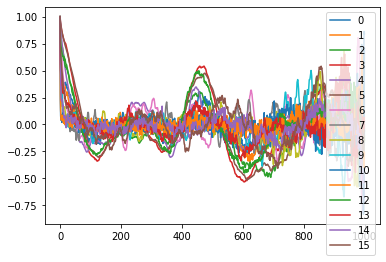

In [7]:
# autocorrelation
for j in range(dim):
    plt.plot(range(samples_off.shape[0]), tfp.stats.auto_correlation(samples_off, axis=0)[:, j], label=f"{j}")
#     plt.plot(range(samples_off.shape[0]), samples_off[:, j], label=f"{j}")
_ = plt.legend()

In [8]:
def plot_sensors(x, lims=None, loc_true=None, extra=None):
    n = x.shape[0]
    nsensors = loc_true.shape[0]
    
    x = tf.reshape(x, (n*nsensors, 2)).numpy()
    loc_true_np = tf.reshape(loc_true, (nsensors, 2)).numpy()
    sensors_ind = [str(i) for i in range(1, nsensors+1)]
    
    plot_df = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], 
                            "sensor": sensors_ind * n})
    loc_true_df = pd.DataFrame({"x0": loc_true_np[:, 0], "x1": loc_true_np[:, 1],
                            "sensor": sensors_ind})
    
    sns.scatterplot(data=plot_df, x="x0", y="x1", hue="sensor")
    plt.scatter(loc_true_df["x0"], loc_true_df["x1"], color="black", marker="v")

    if extra is not None:
        extra_np = tf.reshape(extra, (-1, 2)).numpy()
        plt.scatter(extra_np[:, 0], extra_np[:, 1], color="grey", marker="P")
    
    if lims is not None:
        _ = plt.axis(xmin=lims[0], xmax=lims[1], ymin=lims[2], ymax=lims[3])
        

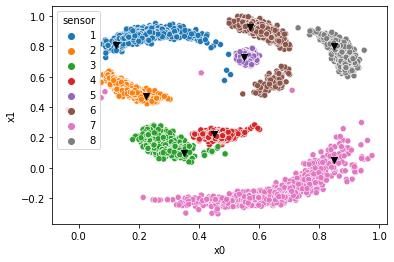

In [9]:
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:8], 
)

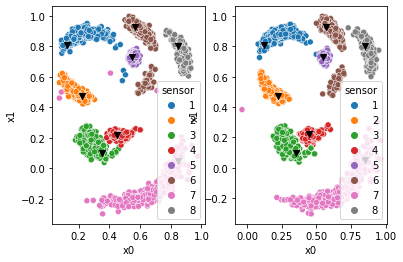

In [10]:
tf.random.set_seed(1)

ntrain = n // 2

samples_init = samples_off

samples_init = tf.random.shuffle(samples_init) # shuffle
# samples_init = samples_init[::-1] #!

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

# sample_off_train = sample_off_train[sample_off_train[:, 11] > 0.7]

plt.subplot(1, 2, 1)
plot_sensors(sample_off_train, loc_true=loc_true[:8])
plt.subplot(1, 2, 2)
plot_sensors(sample_off_test, loc_true=loc_true[:8])
plt.show()

In [11]:
# vanilla ksd test
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [12]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

2022-05-07 10:44:23.576028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=sample_off_train,
                                       multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert)

before:  0.0012484394506866417


In [11]:
threshold = 1e-4

# start_pts = sample_off_train
start_pts = tf.concat([
        sample_off_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=-1., maxval=1.),
    ], axis=0)

tic = time.perf_counter()
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold,
                                      max_iterations=500) #1e-10)
toc = time.perf_counter()
print(f"Optimisation finished in {toc - tic:0.4f} seconds")
len(mode_list)

Optimisation finished in 254.0412 seconds


8

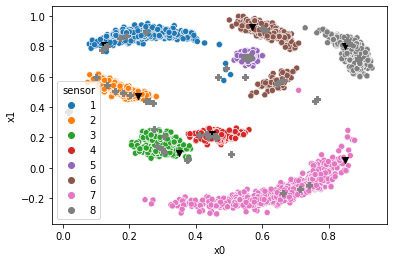

In [12]:
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:8], 
             extra=tf.stack(mode_list)
)

In [13]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([ 0.1895227 ,  0.8659195 ,  0.18227889,  0.4894155 ,  0.29988363,
          0.12090179,  0.46234897,  0.20873804,  0.55802244,  0.7164772 ,
          0.6445577 ,  0.55204314,  0.71314174, -0.14153086,  0.8878944 ,
          0.72473216], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([ 0.1708335 ,  0.8524684 ,  0.2005888 ,  0.47772843,  0.30483922,
          0.10468758,  0.45960408,  0.20882018,  0.5592937 ,  0.7274837 ,
          0.60782975,  0.9108086 ,  0.741683  , -0.1165069 ,  0.8898077 ,
          0.70767456], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([0.24989836, 0.8972412 , 0.13209738, 0.54450655, 0.30292538,
         0.20678045, 0.46160504, 0.19840786, 0.54946417, 0.7242647 ,
         0.6084846 , 0.9063798 , 0.7663007 , 0.45126405, 0.8617018 ,
         0.822771  ], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([0.13143726, 0.80170745, 0

In [14]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

std = [1., 1.048]

T = 10

xx = sample_off_train#[sample_off_train[:, 0] < 0.3]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=xx, ind_pair_list=ind_pair_list, **proposal_dict)

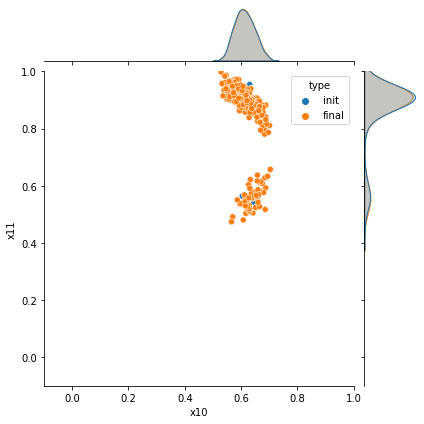

In [15]:
if len(std) > 1:
    x_all = mh.x[-1]
else:
    x_all = mh.x

x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

xtrain_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
xtrain_df["type"] = "mcmc"


perturbed_df = pd.concat([
#     xtrain_df, 
    x0_df, 
    xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x10", y="x11", hue="type",
                  xlim=(-.1, 1.),
                  ylim=(-.1, 1.),
 )

In [16]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [17]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

2022-05-07 08:57:23.981596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.0 
after: 0.0


In [20]:
14860.045 / 3600

4.127790277777778

# Van Dyk's paper

In [2]:
# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob = tf.constant([1., 0, 1, 0, 1, 0, 1, 0])
Ob = tf.transpose(tf.reshape(Ob, (2, -1)))

# Observation indicators among the first four sensors. 
Os = tf.constant([[0., 0, 0, 1],
              [0, 0, 1, 1],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])

# Each row indicates the location of the known sensors (5th and 6th).
Xb = tf.constant([0.5, 0.3, 0.3, 0.7])
Xb = tf.transpose(tf.reshape(Xb, (2, -1)))

# Each row indicates the location of the unknown sensors (1st, 2nd, 3rd, and 4th).
Xs = tf.constant([0.5748, 0.0991, 0.2578, 0.8546, 
               0.9069, 0.3651, 0.1350, 0.0392])
Xs = tf.transpose(tf.reshape(Xs, (2, -1)))

# The observed distances from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Yb = tf.constant([0.6103, 0, 0.2995, 0, 
               0.3631, 0, 0.5656, 0])
Yb = tf.transpose(tf.reshape(Yb, (2, -1)))

# Observed distances among the first four sensors.
Ys = tf.constant([[0, 0, 0, 0.9266],
               [0, 0, 0.2970, 0.8524],
               [0, 0.2970, 0, 0],
               [0.9266, 0.8524, 0, 0]])

loc_true = tf.constant([
    [0.57, 0.91],
    [0.10, 0.37],
    [0.26, 0.14],
    [0.85, 0.04],
#     [0.50, 0.30],
#     [0.30, 0.70]
])

2022-07-31 08:55:10.893074: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-31 08:55:10.893114: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-07-31 08:55:10.893120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-07-31 08:55:10.893222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-07-31 08:55:10.893244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-07-31 08:55:10.893249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-07-31 08:55:10.894046: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [6]:
tf.random.set_seed(1)

dim = 8

loc = tf.random.uniform((2, dim))

target = Sensor(Ob, Os, Xb, Xs, Yb, Ys)
log_prob_fn = target.log_prob

loc2 = tf.concat([loc, loc, loc], axis=0)
log_prob_fn(loc2)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-689.25555, -365.5992 , -689.25555, -365.5992 , -689.25555,
       -365.5992 ], dtype=float32)>

In [16]:
# # check if numpy version is implemented correctly
# from src.sensors import SensorNumpy
# import autograd.numpy as anp

# loc2_np = anp.array(loc2)
# target_np = SensorNumpy(Ob, Os, Xb, Xs, Yb, Ys)
# log_prob_fn_np = target.log_prob
# assert np.allclose(log_prob_fn(loc2), log_prob_fn_np(loc2_np))

In [4]:
import time

tf.random.set_seed(1)

loc = tf.random.uniform((2, 50, dim))

# loc = loc[0, :2]

In [5]:
# start = time.time()
# pp = target.log_prob(loc)
# end = time.time()
# print(end - start)

# start = time.time()
# pp2 = target.log_prob2(loc)
# end = time.time()
# print(end - start)

# print(tf.experimental.numpy.allclose(pp, pp2))
# # print(pp)
# # print(pp2)
# tf.math.abs(pp - pp2)

In [6]:
dim = 8

n = 1000
# ind = tf.range(start=0, limit=800000, delta=800000//n)
ind = tf.constant(range(0, 400*n, 400))

ram_scale = 0.1 #!1.08

# mcmc_res = pd.read_csv(f"res/sensors/modified_ram_{ram_scale}.csv")
# mcmc_res = pd.read_csv(f"res/sensors/modified_ram{ram_scale}/seed1.csv")
mcmc_res = pd.read_csv(f"res/sensors_n_seed9/modified_ram{ram_scale}/seed9.csv")

samples_off = tf.constant(mcmc_res.loc[ind].to_numpy(), dtype=tf.float32)

(1000, 8)


<Figure size 432x288 with 0 Axes>

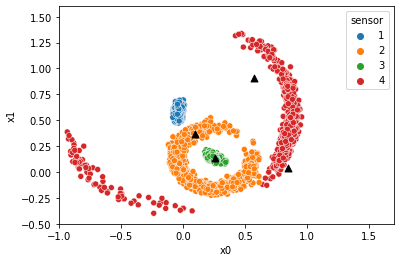

In [7]:
from src.sensors import plot_sensors

# # samples_off = mcmc_res.to_numpy()
# _ = plt.scatter(range(samples_off.shape[0]), samples_off[:, 0])

print(samples_off.shape)
plot_sensors(samples_off, lims=[-1., 1.7, -0.5, 1.6], loc_true=loc_true)

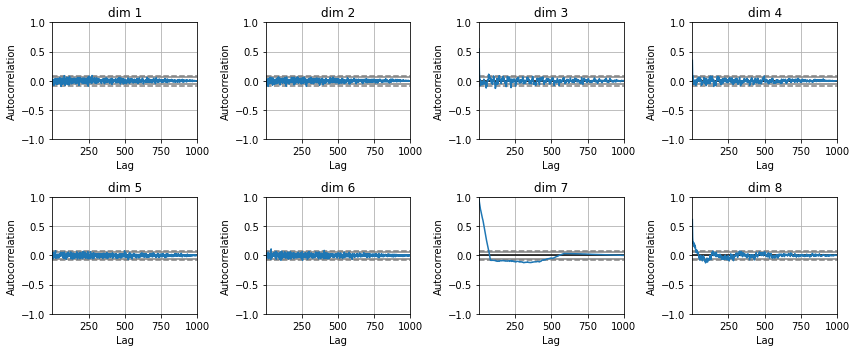

In [8]:
# autocorrelation
plt.figure(figsize=(12, 5))
for i in range(dim):
    plt.subplot(2, dim//2, i+1)
    pd.plotting.autocorrelation_plot(samples_off[:, i])
    plt.title(f"dim {i+1}")

plt.tight_layout()

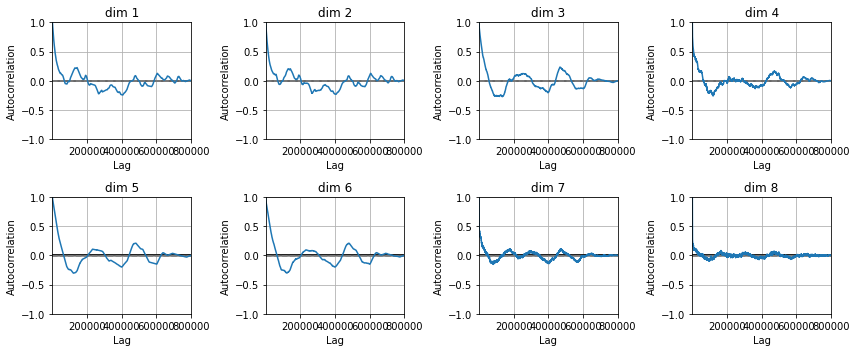

In [8]:
# autocorrelation
plt.figure(figsize=(12, 5))
for i in range(dim):
    plt.subplot(2, dim//2, i+1)
    pd.plotting.autocorrelation_plot(mcmc_res[f"V{i+1}"])
    plt.title(f"dim {i+1}")

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

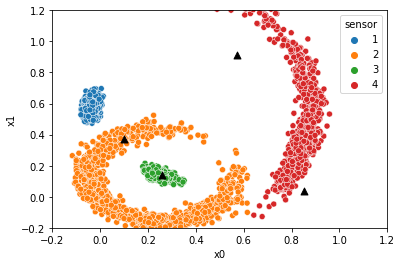

In [9]:
plot_sensors(samples_off, lims=[-0.2, 1.2, -0.2, 1.2], loc_true=loc_true)

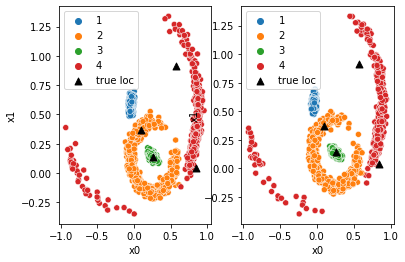

In [141]:
tf.random.set_seed(1)

ntrain = n // 2

samples_init = samples_off

samples_init = tf.random.shuffle(samples_init) # shuffle
# samples_init = samples_init[::-1] #!

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

plt.subplot(1, 2, 1)
plot_sensors(sample_off_train, loc_true=loc_true)
plt.subplot(1, 2, 2)
plot_sensors(sample_off_test, loc_true=loc_true)
plt.show()

In [142]:
# vanilla ksd test
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [143]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [144]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=sample_off_train,
                                       multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert)

before:  0.22971285892634208


In [172]:
threshold = 1e-4

# start_pts = sample_off_train
start_pts = tf.concat([
        sample_off_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=-1., maxval=1.),
    ], axis=0)

tic = time.perf_counter()
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold,
                                      max_iterations=1000)
toc = time.perf_counter()
print(f"Optimisation finished in {toc - tic:0.4f} seconds")
len(mode_list)

Optimisation finished in 88.7350 seconds


8

<Figure size 432x288 with 0 Axes>

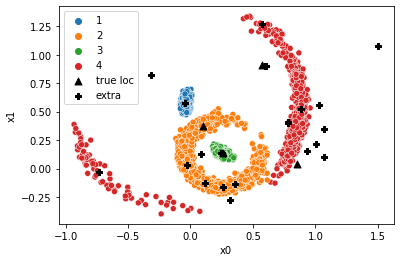

In [173]:
# show_jumps(sample_off_train, mode_list=mode_list[:2])
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:4], 
             extra=tf.stack(mode_list)
)

In [174]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.03984767,  0.5797991 ,  0.35594508, -0.13920383,  0.25063473,
          0.13763925,  0.88211596,  0.52746975], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04039392,  0.5801166 ,  0.11468072, -0.12580149,  0.24997082,
          0.13788736, -0.7289568 , -0.03380398], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04015436,  0.5788234 ,  1.0322891 ,  0.5598411 ,  0.7796818 ,
          0.4051033 ,  0.5696557 ,  1.2714574 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([ 0.6010138 ,  0.8994257 , -0.02684855,  0.02904074,  0.24809898,
          0.13931583, -0.31889272,  0.8259954 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([ 0.60244215,  0.8985395 ,  0.25975648, -0.15744883,  0.24921238,
          0.13860418,  1.068163  ,  0.10187761], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([0.6

In [175]:
tf.linalg.det(tf.linalg.inv(inv_hess_list[0]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.4450526e+24>

In [176]:
# #! impose inv hessians
inv_hess_list_old = inv_hess_list
inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

In [177]:
# #! select only two modes
# mode_list, inv_hess_list = mode_list[:2], inv_hess_list[:2]

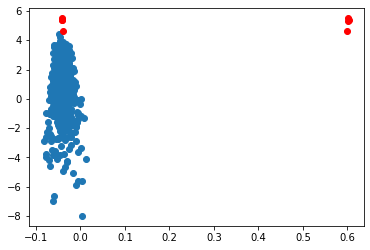

In [178]:
xx = sample_off_train.numpy()
_ = plt.scatter(xx[:, 0], log_prob_fn(xx))
yy = tf.stack(mode_list, axis=0)
_ = plt.scatter(yy[:, 0], log_prob_fn(yy), color="red")

In [179]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [180]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [181]:
std = tf.linspace(0.1, 1.1, 201) #1.048

In [182]:
T = 1000

xx = sample_off_train#[sample_off_train[:, 0] < 0.3]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=xx, ind_pair_list=ind_pair_list, **proposal_dict)

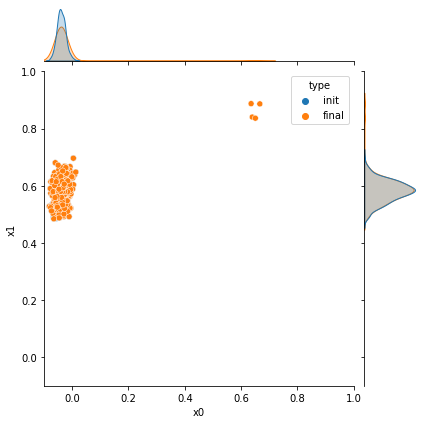

In [183]:
if len(std) > 1:
    x_all = mh.x[-1]
else:
    x_all = mh.x
    
x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

xtrain_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
xtrain_df["type"] = "mcmc"


perturbed_df = pd.concat([
#     xtrain_df, 
    x0_df, 
    xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x0", y="x1", hue="type",
                  xlim=(-.1, 1.),
                  ylim=(-.1, 1.),
 )

In [184]:
np.sum((x_t[:, 0] > 0.2)) #51

4

<Figure size 432x288 with 0 Axes>

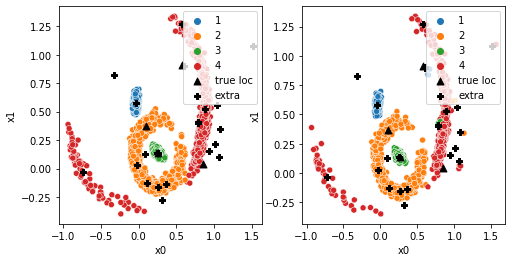

In [185]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:4], 
             extra=tf.stack(mode_list)
)

plt.subplot(1, 2, 2)
plot_sensors(x_t, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:4], 
             extra=tf.stack(mode_list)
)

In [186]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [70]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [187]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.22971285892634208 
after: 0.1560549313358302


In [188]:
# previous pval before: 0.451
# previous pval after: 0.07 with 20-th jump scale

In [189]:
end_T = -1

scaled_ksd_vals = []
unscaled_ksd_vals = []

for j in range(std.shape[0]):
    x_t = mh.x[j, end_T, :, :]
    var, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
    ksd_unscaled = ksd_val * tf.math.sqrt(var)

    scaled_ksd_vals.append(ksd_val)
    unscaled_ksd_vals.append(ksd_unscaled.numpy())

best_jump = std[tf.math.argmax(scaled_ksd_vals)]
print("best jump:", best_jump.numpy())

x_t = mh.x[tf.math.argmax(scaled_ksd_vals), end_T, :, :]
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

best jump: 1.035
before:  0.22971285892634208 
after: 0.05742821473158552


In [185]:
'''
0.1:
best jump: 0.984
before:  0.24344569288389514 
after: 0.0149812734082397

0.3：
best jump: 0.96800005
before:  0.10362047440699126 
after: 0.018726591760299626

0.5:
best jump: 0.992
before:  0.6841448189762797 
after: 0.5630461922596754

0.7:
best jump: 0.976
before:  0.6229712858926342 
after: 0.1647940074906367

1.0：
best jump: 1.008
before:  0.04868913857677903 
after: 0.033707865168539325

1.08:
best jump: 0.976
before:  0.02247191011235955 
after: 0.04369538077403246

1.2:
best jump: 1.008
before:  0.02247191011235955 
after: 0.003745318352059925
'''

'\n0.5:\nbest jump: 0.992\nbefore:  0.6841448189762797 \nafter: 0.5630461922596754\n\n1.0：\nbest jump: 1.008\nbefore:  0.04868913857677903 \nafter: 0.033707865168539325\n\n1.08:\nbest jump: 0.976\nbefore:  0.02247191011235955 \nafter: 0.04369538077403246\n\n1.2:\nbest jump: 1.008\nbefore:  0.02247191011235955 \nafter: 0.003745318352059925\n'

In [20]:
def experiment(n, target_dist, samples_init, sample_init_train, sample_init_test):
    jump_ls = tf.linspace(0.8, 1.2, 51)
    
    ntrain = n // 2
    threshold = 1e-2
    nrep = 1

    num_boot = 800
    alpha = 0.05
    T = 3000
    
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n-ntrain)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))

    p_val_list = []
    jump_ratio_list = []

    i = 0
    # sample data
    start_pts = tf.concat([
        sample_init_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=0., maxval=1.)], axis=0)

    plt.subplot(1, 2, 1)
    plot_sensors(sample_off_train)
    plt.subplot(1, 2, 2)
    plot_sensors(sample_off_test)
    plt.show()
    
    # find modes
    print("searching for modes")
    mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)
    
    #!
    inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

    proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)
    _, ind_pair_list = pairwise_directions(mode_list, return_index=True)

    print("running in parallel ...")
    tic = time.perf_counter()

    # find best jump scale
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=jump_ls, x_init=sample_init_train, ind_pair_list=ind_pair_list, **proposal_dict)

    # compute ksd
    unscaled_ksd_vals = []
    scaled_ksd_vals = []
    for j in range(jump_ls.shape[0]):
        x_t = mh.x[j, -1, :, :]
        var, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
        ksd_unscaled = ksd_val * tf.math.sqrt(var)
        
        scaled_ksd_vals.append(ksd_val)
        unscaled_ksd_vals.append(ksd_unscaled.numpy())
    
    toc = time.perf_counter()
    print(f"... done in {toc - tic:0.4f} seconds")
    best_jump = jump_ls[tf.math.argmax(scaled_ksd_vals)]

    # mh perturbation
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=best_jump, x_init=sample_off_test, 
           ind_pair_list=ind_pair_list, **proposal_dict)
    x_0 = mh.x[0, :, :]
    x_t = mh.x[-1, :, :]

    # compute p-value
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)

    multinom_one_sample = multinom_samples[i, :]

    _, p_val0 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)
    unscaled_ksd0 = bootstrap.ksd_hat
    _, p_valt = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
    unscaled_ksdt = bootstrap.ksd_hat
    
    p_val_list.append(p_val0) # no perturbation
    jump_ratio_list.append(-1.)
    
    p_val_list.append(p_valt)
    jump_ratio_list.append(best_jump.numpy())
        
    res = pd.DataFrame({"pval": p_val_list, "jump": jump_ratio_list, 
                        "ksd": [unscaled_ksd0, unscaled_ksdt]})
    
    return res, unscaled_ksd_vals

2022-05-05 10:10:20.021252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


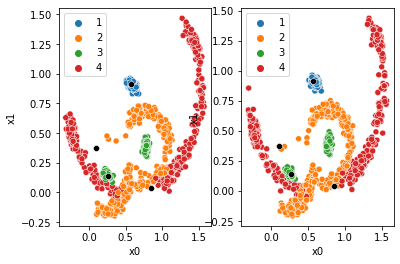

searching for modes
running in parallel ...
... done in 695.6825 seconds
Finished in 928.5214 seconds


In [21]:
tf.random.set_seed(1)
tic = time.perf_counter()
res_df2, unscaled_ksd_vals2 = experiment(n, target, samples_init=samples_off,
                              sample_init_train=sample_off_train,
                              sample_init_test=sample_off_test,
                              )
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

In [22]:
res_df2

,pval,jump,ksd
0,0.187266,-1.000,19.806453
1,0.049938,1.048,42.093727


In [24]:
# unscaled_ksd_vals2

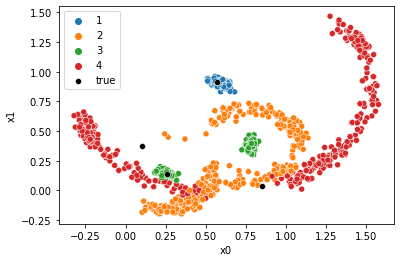

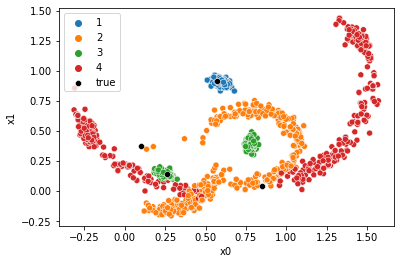

searching for modes
running in parallel ...
... done in 489.8636 seconds
Finished in 678.9540 seconds


In [51]:
tf.random.set_seed(1)
tic = time.perf_counter()
res_df, unscaled_ksd_vals = experiment(n, target, samples_init=samples_off,
                              sample_init_train=sample_off_train,
                              sample_init_test=sample_off_test,
                              )
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

In [52]:
print(res_df)

       pval   jump        ksd
0  0.187266 -1.000  19.806453
1  0.059925  1.048  43.789603
